In [1]:
import torch
import cv2
import numpy as np
import json

from torchvision.models import resnet18 as resnet18
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.quantization import resnet18 as resnet18_q
from torchvision import transforms as T

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Классификация (fp32)

## Загрузка/сохранение модели

PyTorch предоставляет набор предобученных моделей. Чтобы ими воспользоваться, достаточно указать pretrained=True, а также перевести в режим eval

In [3]:
classifier = resnet18(pretrained=True).eval()

Веса хранятся в state_dict в виде словаря

In [4]:
sd = classifier.state_dict()
sd.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

Веса можно сохранить на диск. Как правило, такая операция производится в процессе обучения - checkpoints

In [5]:
torch.save(classifier.state_dict(), 'resnet18.pth')

Сохраненные таким образом веса можно загрузить в модель

In [6]:
sd = torch.load('resnet18.pth')
classifier.load_state_dict(sd)

<All keys matched successfully>

## Исследование архитектуры

### Текстовое представление и доступ к блокам

Архитектуру модели можно легко визуализировать в тектовом виде

In [7]:
classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Доступ к отдельным блокам/слоям модели осуществляется по имени/индексу

In [8]:
classifier.layer1[1]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
classifier.layer1[1].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Свертоный слой содержит тензор весов, который при сохранении на диск имеет ключ layer1.1.conv1.weight

In [10]:
classifier.layer1[1].conv1.weight.shape

torch.Size([64, 64, 3, 3])

### ONNX и Netron

Для визуализации архитектуры модели можно экспортировать её в формате [ONNX](https://onnx.ai/) и визуализировать в [Netron](https://netron.app/)

In [11]:
torch.onnx.export(classifier, torch.randn(1, 3, 224, 224), 'resnet18.onnx')

/mnt/shared/progs/miniconda3/envs/py3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


![title](../imgs/resnet18.onnx.png)

## Считывание и подготовка входных данных

In [12]:
IMAGE_PATH = '../imgs/monkey.png'

OpenCV часто используется для обработки изображений, есть интерфейсы для python и C++.

In [13]:
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV повсеместно использует BGR формат представления цвета

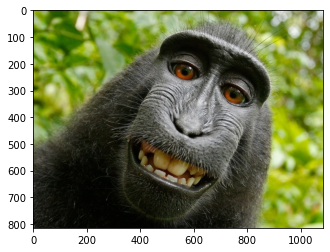

In [14]:
plt.imshow(image)

In [15]:
image.shape

(814, 1085, 3)

In [16]:
h, w = image.shape[:2]

Модель была обучена на изображениях 224x224, поэтому предобразуем входное изображение к такому формату

In [17]:
image = image[:, (w - h) // 2:(w - h) // 2 + h]  # center crop

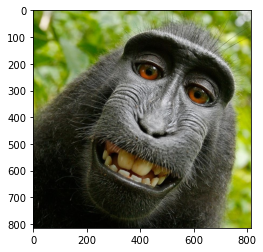

In [18]:
plt.imshow(image)

In [19]:
image = cv2.resize(image, (224, 224))

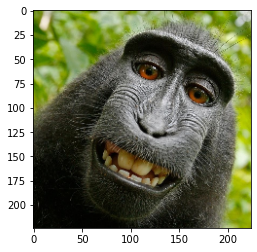

In [20]:
plt.imshow(image)

Изначально изображение содержит величины интенсивности компонент RGB в диапазоне 0..255. Модели, как правило, принимают на вход нормализованные данные в виде чисел с плавающей точкой:

In [21]:
image_tensor = torch.Tensor(image).float() / 255  # переводим в диапазон 0..1

In [22]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

image_tensor = (image_tensor - mean) / std  # делаем нормализацию

In [23]:
image_tensor.shape

torch.Size([224, 224, 3])

В PyTorch принято, что канал цвета задан первой размерностью, а не последней

In [24]:
image_tensor = image_tensor.permute(2, 0, 1)

In [25]:
image_tensor.shape

torch.Size([3, 224, 224])

Модели обрабатывают данные в виде батчей - наборов нескольких изображений

In [26]:
batch = image_tensor.unsqueeze(0)

In [27]:
batch.shape

torch.Size([1, 3, 224, 224])

In [28]:
if torch.cuda.is_available():
    batch = batch.cuda()

if torch.cuda.is_available():
    classifier = classifier.cuda()

Произведем измерение скорости инференса. Обратите внимание на torch.cuda.synchronize(). CUDA операции выполняются асинхронно, то есть когда выполняется команда logits = classifier(batch), то процесс вычислений ставится в очередь, а не начинает выполняться незамедлительно. Кроме того, выход из этой операции не гарантирует завершение процесса вычислений. Однако, после синхронизации, все вычисления, поставленные в очередь до нее гарантированно завершаются.

In [29]:
%%timeit
with torch.no_grad():
    logits = classifier(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

2.31 ms ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
with torch.no_grad():
    logits = classifier(batch)

Для получения вероятностей классов применим softmax

In [31]:
probs = torch.softmax(logits, 1)

Выберем топ-5 классов, в которых уверена модель

In [32]:
topk = torch.topk(logits, 5)

In [33]:
topk

torch.return_types.topk(
values=tensor([[13.2837, 12.4374, 11.4100, 11.0296, 10.8568]], device='cuda:0'),
indices=tensor([[370, 369, 366, 368, 367]], device='cuda:0'))

In [34]:
with open('imagenet1000_clsidx_to_labels.json', 'r') as f:
    imagenet1k_clsidx_to_labels = json.load(f)

In [35]:
for v in topk.indices[0]:
    print(imagenet1k_clsidx_to_labels[v])

guenon
siamang
gorilla
gibbon
chimpanzee


## Классификация (int8)

Модели могут выполняться не с использованием float point 32, а с использованием чисел меньшей разрядности. Это позволяет уменьшить энергопотребление и увеличить скорость работы

In [36]:
classifier_q = resnet18_q(pretrained=True, quantize=True).eval()

/mnt/shared/progs/miniconda3/envs/py3.8/lib/python3.8/site-packages/torch/quantization/observer.py:122: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [37]:
batch = batch.cpu()

In [38]:
%%timeit
with torch.no_grad():
    logits = classifier_q(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

4.54 ms ± 74.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
with torch.no_grad():
    logits = classifier_q(batch)

In [40]:
topk = torch.topk(logits, 5)

In [41]:
topk

torch.return_types.topk(
values=tensor([[13.1066, 12.5368, 11.6820, 11.1122, 11.1122]]),
indices=tensor([[370, 369, 366, 368, 367]]))

In [42]:
for v in topk.indices[0]:
    print(imagenet1k_clsidx_to_labels[v])

guenon
siamang
gorilla
gibbon
chimpanzee


## Семантическая сегментация

In [43]:
segmentator = fcn_resnet50(pretrained=True).eval()

In [44]:
if torch.cuda.is_available():
    segmentator = segmentator.cuda()

In [45]:
image = cv2.imread('../imgs/kitti.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

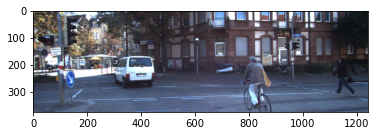

In [46]:
plt.imshow(image)

In [47]:
image_tensor = torch.Tensor(image).float() / 255

In [48]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

image_tensor = (image_tensor - mean) / std

In [49]:
image_tensor = image_tensor.permute(2, 0, 1)

In [50]:
batch = image_tensor.unsqueeze(0)

In [51]:
if torch.cuda.is_available():
    batch = batch.cuda()

In [52]:
%%timeit
with torch.no_grad():
    logits = segmentator(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

67.2 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
with torch.no_grad():
    logits = segmentator(batch)

In [54]:
probs = torch.softmax(logits['aux'][0], 0)

In [55]:
with open('coco_clsidx_to_labels.json', 'r') as f:
    coco_clsidx_to_labels = json.load(f)

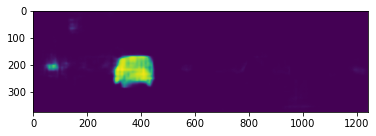

In [56]:
plt.imshow(probs.cpu()[coco_clsidx_to_labels.index('car')])

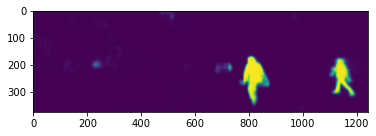

In [57]:
plt.imshow(probs.cpu()[coco_clsidx_to_labels.index('person')])

In [58]:
classes = probs.argmax(dim=0) * (probs.max(dim=0).values > 0.5)

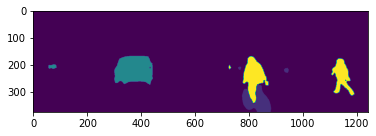

In [59]:
plt.imshow(classes.cpu())

In [60]:
rgb_pallete = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 255],  # bicycle
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [255, 0, 0],  # car
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 255, 0],  # person
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

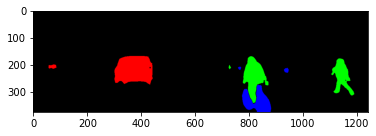

In [61]:
plt.imshow(rgb_pallete[classes.cpu()])